In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import logging

## Feature-scaling stack
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer

## Dimesionality reduction
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

## Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN

## Machine-learning stack
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, auc, fbeta_score, f1_score

## Model saving
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

# Control Variables

In [2]:
ENABLE = {
    'rf':     {'cross-val':    0,
               'compute-pauc': 0,
               'final-train':  0,
               'save-model':   0,
              },
    'xgb':    {'cross-val':    0,
               'compute-pauc': 1,
               'final-train':  0,
               'save-model':   0,
              },
    'lgb':    {'cross-val':    0,
               'compute-pauc': 1,
               'final-train':  0,
               'save-model':   0,
              },
    'cb':     {'cross-val':    0,
               'compute-pauc': 0,
               'final-train':  0,
               'save-model':   0,
              },
    'ada':    {'cross-val':    0,
               'compute-pauc': 0,
               'final-train':  0,
               'save-model':   0,
              },
    'svc':    {'cross-val':    0,
               'compute-pauc': 0,
               'final-train':  0,
               'save-model':   0,
              },
    'gbm':    {'cross-val':    0,
               'compute-pauc': 1,
               'final-train':  0,
               'save-model':   0,
              },
    'soft-v': {'cross-val':    1,
               'compute-pauc': 1,
               'final-train':  0,
               'save-model':   0,
              },
    'lr-v':   {'cross-val':    0,
               'compute-pauc': 0,
               'final-train':  0,
               'save-model':   0,
              },
}

# Evaluation Functions

In [3]:
def partial_auc_score(y_actual, y_scores, tpr_threshold=0.80):
    max_fpr = 1 - tpr_threshold

    # create numpy arrays
    y_actual = np.asarray(y_actual)
    y_scores = np.asarray(y_scores)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_actual, y_scores)

    # Find the index where fpr exceeds max_fpr
    stop_index = np.searchsorted(fpr, max_fpr, side='right')

    if stop_index < len(fpr):
        # Interpolate to find the TPR at max_fpr
        fpr_interp_points = [fpr[stop_index - 1], fpr[stop_index]]
        tpr_interp_points = [tpr[stop_index - 1], tpr[stop_index]]
        tpr = np.append(tpr[:stop_index], np.interp(max_fpr, fpr_interp_points, tpr_interp_points))
        fpr = np.append(fpr[:stop_index], max_fpr)
    else:
        tpr = np.append(tpr, 1.0)
        fpr = np.append(fpr, max_fpr)

    # Calculate partial AUC
    partial_auc_value = auc(fpr, tpr)

    return partial_auc_value

def cross_val_partial_auc_score(X, y, model, n_splits, verbose=1):

     # Setup cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    pauc_scores = []
    cont = 1
   
    for train_idx, val_idx in skf.split(X, y):

        if verbose == 1:
            print(f'Processing fold {cont} of {n_splits}... ', end='', flush=True)
        
        # Create the folds
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                
        # Train the model
        model.fit(X_train_fold, y_train_fold)
    
        # Predict on the validation set
        preds = model.predict_proba(X_val_fold)[:,1]
   
        # Calculate partical AUC and store it
        pauc = partial_auc_score(y_val_fold, preds)
        pauc_scores.append(pauc)

        if verbose == 1:
            print(f'pAUC: {pauc}', flush=True)

        #predictions.append((val_idx, preds))
        
        cont = cont + 1
    
    # Return the average
    return np.mean(pauc_scores)

def plot_feature_importance(importances, features_names):

    # Create a dataframe
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances,
    }).sort_values(by='importance', ascending=False)
    
    # Plot feature importance
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot()
    sns.barplot(x='feature', y='importance', data=feature_importance, ax=ax)
    plt.xticks(rotation=90, ha='right')
    plt.title('Feature Importance', fontsize=16)
    plt.xlabel('Feature', fontsize=14)
    plt.ylabel('Importance', fontsize=14)
    #plt.tight_layout()
    plt.show()

# Model Loading

In [4]:
# Read the metadata-based feature set
#ROOT_DATASET_DIR = "./"
#file_name_data = os.path.join(ROOT_DATASET_DIR,"train-metadata-eda-fe-v2-kaggle.csv")
df_meta = pd.read_csv('train-metadata-eda-fe-v3-kaggle.csv')

# Read the image (pixel)-based feature set
#file_name_img = os.path.join(ROOT_DATASET_DIR,"train-cnn-crossval-preds-rn152v2_v1.csv")
df_img = pd.read_csv('train-cnn-crossval-preds-rn152v2_v2.csv')

# Merge with Cross-val CNN Predictions

In [5]:
# Force categorical features to be categorical
df_meta['anatom_site_general'] = pd.Categorical(df_meta['anatom_site_general'])
df_meta['tbp_lv_location'] = pd.Categorical(df_meta['tbp_lv_location'])
df_meta['tbp_lv_location_simple'] = pd.Categorical(df_meta['tbp_lv_location_simple'])
df_meta['sex'] = pd.Categorical(df_meta['sex'])

# Remove the target column in the cross-vall cnn prediction vector
df_img.drop(columns=['target'], inplace=True)

# Merge the dataframes and remove 'isic_id'
df = pd.merge(df_meta, df_img, on='isic_id', how='left') #inner is also ok
df.drop(columns=['isic_id'], inplace=True)

# Preparing Feature Dataset and Targets

In [6]:
# Train-Test split
# Drop non-used features for the baseline + target
X = df.drop(['target']      
            ,
             axis=1)
y = df['target']

In [7]:
cnn_feature = ['crossval_cnn_preds']
numerical_features = X.select_dtypes(include=['float64','int64']).columns.tolist()
numerical_features.remove('crossval_cnn_preds')
categorical_features = X.select_dtypes(include=['category']).columns.tolist()
print(f"Numerical features: {numerical_features} - Length: {len(numerical_features)}")
print(f"Categorical features: {categorical_features} - Length: {len(categorical_features)}")

Numerical features: ['age_approx', 'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'sqr_tbp_lv_eccentricity', 'lesion_size_ratio', 'lesion_shape_index', 'hue_contrast', 'luminance_contrast', 'lesion_color_difference', 'border_complexity', 'position_distance_3d', 'log_perimeter_to_area_ratio', 'area_to_perimeter_ratio', 'lesion_visibility_score', 'symmetry_border_consistency', 'consistency_symmetry_border', 'color_consistency', 'consistency_colo

# Dimensionality Reduction Analysis

In [8]:
def apply_kbest(X, y, threshold):

    # Identify numerical and categorical features
    numerical_features = X.select_dtypes(include=['float64','int64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['category']).columns.tolist()
    
    # Use SelectKBest (f_classif) for numerical features
    Kbest_numerical = SelectKBest(score_func=f_classif, k='all')
    Kbest_numerical.fit(X[numerical_features], y)
    
    # Extract feature scores and p-values
    scores = Kbest_numerical.scores_
    pvalues = Kbest_numerical.pvalues_
    
    # Create a DataFrame to save feature names, scores, and p-values
    feature_scores = pd.DataFrame({
        'Feature': numerical_features,
        'Score': scores,
        'P-Value': pvalues
    })
    
    # Sort features by 'Score'
    best_feature_scores = feature_scores[feature_scores['P-Value'] < threshold]
    sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)
    
    # Display the sorted features
    kbest_num = sorted_features.shape[0]
    print(f"Number of relevant numerical features: {kbest_num}\n")
    print(sorted_features.set_index('Feature'))
    
    #best_numerical_features = sorted_features.index.tolist()
    
    # Plot feature importance
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot()
    sns.barplot(x='Feature', y='Score', data=sorted_features, ax=ax)
    plt.xticks(rotation=90, ha='right')
    plt.title('Feature Importance - Numerical', fontsize=16)
    plt.xlabel('Feature', fontsize=14)
    plt.ylabel('Importance', fontsize=14)
    #plt.tight_layout()
    plt.show()
    
    # Use SelectKBest (chi2) for categorical features

    # Build a pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
        ],
        remainder='drop'
    )
    
    pipeline = Pipeline(steps=[
        ('onehot', preprocessor),
        ('kbest', SelectKBest(score_func=chi2, k='all'))
    ])
    
    cat_transformed = pipeline.fit_transform(X, y)
    Kbest_categorical = pipeline.named_steps['kbest']
    
    # Extract feature scores and p-values
    scores = Kbest_categorical.scores_
    pvalues = Kbest_categorical.pvalues_
    
    # Extract feature names after one-hot encoding
    one_hot_feature_names = pipeline.named_steps['onehot'].transformers_[0][1].get_feature_names_out(categorical_features)
    
    # Create a DataFrame to hold feature names, scores, and p-values
    feature_scores = pd.DataFrame({
        'Feature': one_hot_feature_names,
        'Score': scores,
        'P-Value': pvalues
    })
    
    # Sort features by their scores
    best_feature_scores = feature_scores[feature_scores['P-Value'] < threshold]
    sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)
    
    # Display the sorted features
    kbest_cat = sorted_features.shape[0]
    print(f"Number of relevant categorical features: {kbest_cat}\n")
    print(sorted_features.set_index('Feature'))

     # Plot feature importance
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot()
    sns.barplot(x='Feature', y='Score', data=sorted_features, ax=ax)
    plt.xticks(rotation=90, ha='right')
    plt.title('Feature Importance - Categorical', fontsize=16)
    plt.xlabel('Feature', fontsize=14)
    plt.ylabel('Importance', fontsize=14)
    #plt.tight_layout()
    plt.show()
    
    #best_categorical_features = sorted_features.index.tolist()
    
    return kbest_num, kbest_cat

    #best_features = best_numerical_features + best_categorical_features

Number of relevant numerical features: 78

                               Score        P-Value
Feature                                            
crossval_cnn_preds       4437.105741   0.000000e+00
tbp_lv_areaMM2            820.761461  2.531843e-180
tbp_lv_H                  810.064722  5.299787e-178
volume_approximation_3d   757.924108  1.092496e-166
mean_hue_difference       685.574310  5.521188e-151
...                              ...            ...
texture_uniformity          8.768705   3.064612e-03
border_density              7.883024   4.990341e-03
area_diameter_ratio         7.833223   5.129703e-03
tbp_lv_L                    6.699025   9.646915e-03
3d_position_angle_xz        4.017118   4.504131e-02

[78 rows x 2 columns]


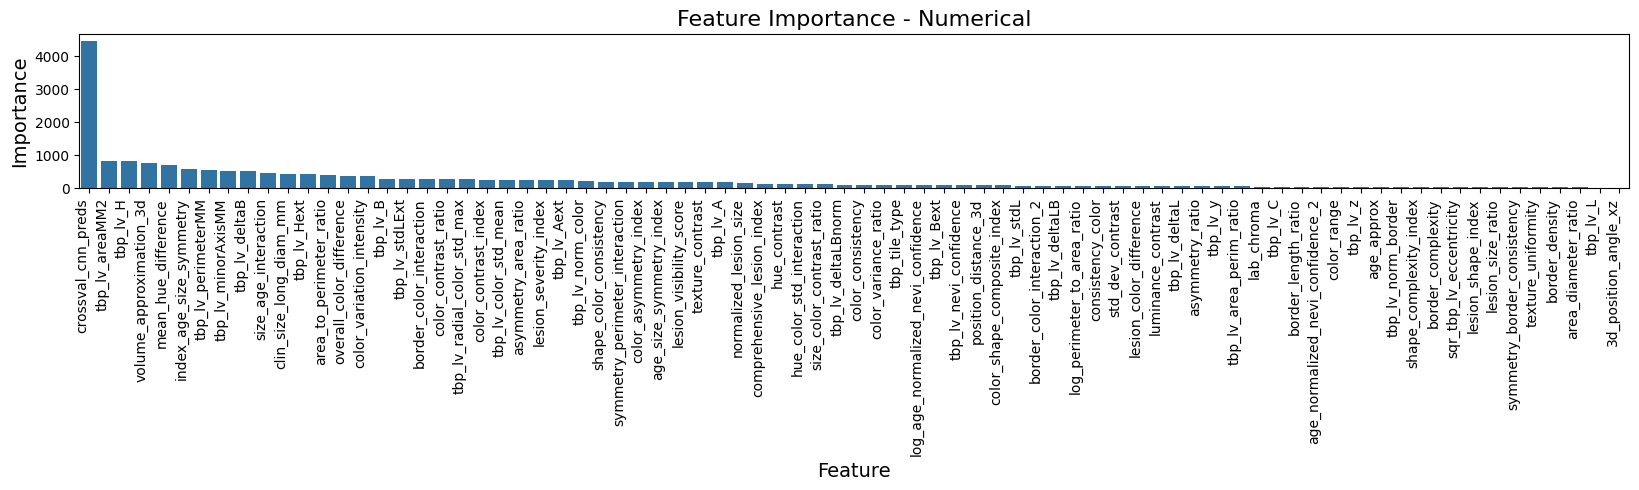

Number of relevant categorical features: 8

                                              Score       P-Value
Feature                                                          
anatom_site_general_head/neck            364.361682  3.161229e-81
tbp_lv_location_Right Leg - Upper         15.614025  7.767632e-05
tbp_lv_location_simple_Right Leg           8.605018  3.352381e-03
anatom_site_general_lower extremity        8.463089  3.624258e-03
tbp_lv_location_Left Leg                   8.314718  3.932510e-03
tbp_lv_location_Torso Front Bottom Half    5.201509  2.256728e-02
tbp_lv_location_Torso Back Middle Third    4.221756  3.990885e-02
tbp_lv_location_Left Leg - Upper           3.866920  4.924681e-02


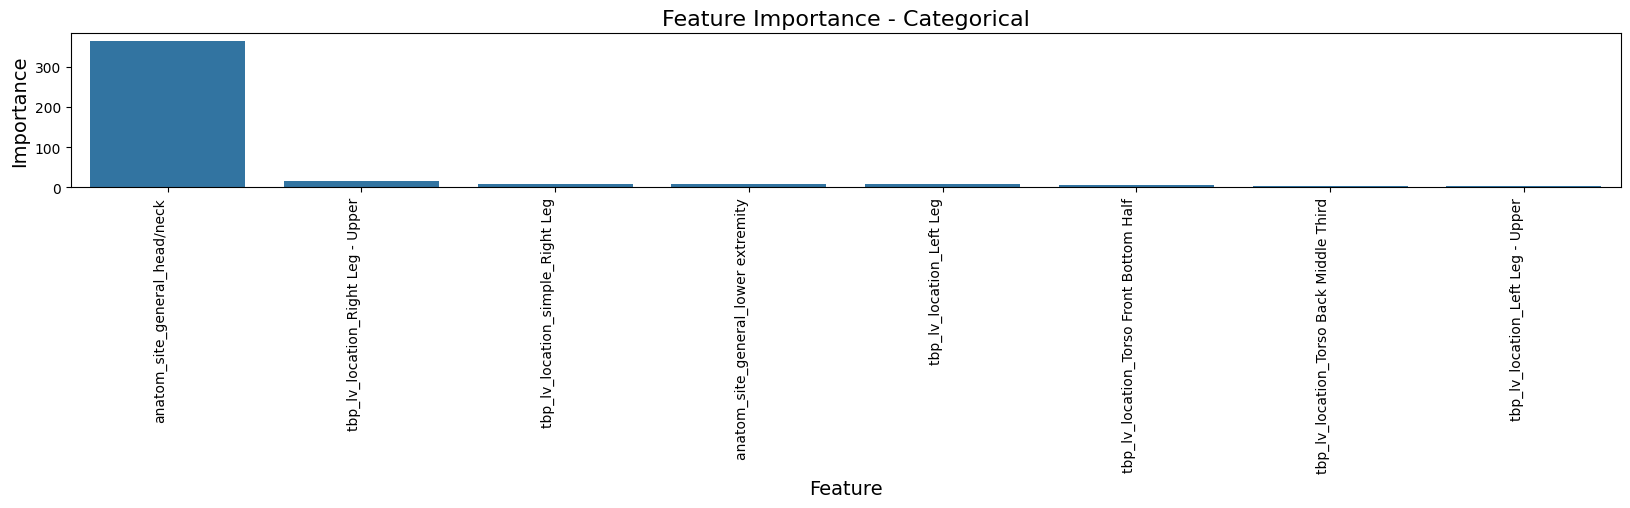

In [9]:
KBEST_NUM, KBEST_CAT = apply_kbest(X, y, 0.05)

# Preprocessing Pipeline 

In [10]:
# Pipeline
from sklearn.preprocessing import FunctionTransformer
   
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    #('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)), # From KBest   
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    #('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)), # From KBest
])

preprocessing = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    #('numerical', 'passthrough', numerical_features + cnn_feature),
    ('cnn', 'passthrough', cnn_feature),
    ('categorical', pipe_cat, categorical_features),    
])

In [11]:
preprocessing

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['age_approx', 'clin_size_long_diam_mm',
                                  'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext',
                                  'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C',
                                  'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext',
                                  'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
                                  'tbp_lv_area_perim_ratio',
                                  'tbp_lv_color_std_mean', 'tbp_lv_deltaA...
                                  'tbp_lv_norm_border', 'tbp_lv_norm_color',
                                  'tbp_lv_perimeterMM',
                                  'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
                                  'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', ...]),
                                ('cnn', 'passthrough', ['crossval_cnn_preds']),
                                ('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sex', 'anatom_site_general',
                                  'tbp_lv_location',
                                  'tbp_lv_location_simple'])])

# Balanced Random Forest

### Cross-validation

In [12]:
if ENABLE['rf']['cross-val'] == 1:
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):
        # Suggest values for the hyperparameters
        random_state = 42
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        max_features = trial.suggest_categorical('max_features', [None, 'sqrt'])
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        max_depth = trial.suggest_int('max_depth', 5, 40) #10, #30)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10) #7)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20) #1, 20) #10) #5)   
        bootstrap=True
        class_weight=trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    
        pauc_scores = []
    
        for train_idx, val_idx in skf.split(X, y):
            
            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                        
            # Pipeline                           
            pipe_rf = ImbPipeline([
                ('preprocessing', preprocessing),
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
                ('RF', BalancedRandomForestClassifier(random_state=random_state,
                                                      n_estimators=n_estimators,
                                                      max_features=max_features,
                                                      criterion=criterion,
                                                      max_depth=max_depth,
                                                      min_samples_split=min_samples_split,
                                                      min_samples_leaf=min_samples_leaf,
                                                      bootstrap=bootstrap,
                                                      class_weight=class_weight
                                                     )
                )
            ])
    
            # Train the model
            pipe_rf.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_rf.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=500, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')

### Cross-validation Partial AUC Score

In [13]:
# Parameters
param_rf = {
    'random_state':      42,
    'bootstrap':         True,
    'n_jobs':            -1,
    'n_estimators':      423,
    'max_features':      'sqrt',
    'criterion':         'entropy', 
    'max_depth':         16,
    'min_samples_split': 7,
    'min_samples_leaf':  11,    
    'class_weight':      'balanced_subsample',
}

# Model pipeline
model_rf_cv = ImbPipeline([    
    ('preprocessing', preprocessing),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
    ('RF',  BalancedRandomForestClassifier(**param_rf))
])

# Cross-validation Partial AUC score
if ENABLE['rf']['compute-pauc'] == 1:
    pauc_rf_cv = cross_val_partial_auc_score(X, y, model_rf_cv, n_splits=5)    
    print(f"CV Partial AUC Score: {pauc_rf_cv}")

### Final Training

In [14]:
if ENABLE['rf']['final-train'] == 1:

    # Model pipeline
    model_rf = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('RF',  BalancedRandomForestClassifier(**param_rf))
    ])

    # Fit with the whole dataset
    model_rf.fit(X, y)

    # Feature importance analysis
    importances = model_rf.named_steps['RF'].feature_importances_
    feature_names = model_rf.named_steps.preprocessing.get_feature_names_out()
    plot_feature_importance(importances, feature_names)

### Model Saving

In [15]:
if ENABLE['rf']['save-model'] == 1:
    dump(model_rf, 'model_rf.pkl')

# XGBoost

### Cross-validation

In [16]:
if ENABLE['xgb']['cross-val'] == 1:

    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):

        # Suggest values for the hyperparameters
        random_state = 42
        eval_metric = 'logloss'
        enable_categorical = True
        n_estimators = trial.suggest_int('n_estimators', 200, 500)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
        reg_lambda = trial.suggest_float('reg_lambda', 5.0, 10.0)
        alpha = trial.suggest_float('alpha', 0.5, 0.8)
        max_depth = trial.suggest_int('max_depth', 10, 40) #31)
        subsample = trial.suggest_float('subsample', 0.45, 0.70)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.80, 1.0)
        colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.4, 0.7)
        scale_pos_weight = trial.suggest_float('scale_pos_weight', 1, 10)
    
        pauc_scores = []
    
        for train_idx, val_idx in skf.split(X, y):
            
            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                    
            # Pipeline                           
            pipe_xgb = ImbPipeline([
                ('preprocessing', preprocessing),
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
                ('XGB', XGBClassifier(random_state=random_state,
                                      eval_metric=eval_metric,
                                      enable_categorical=enable_categorical,
                                      n_estimators=n_estimators,
                                      learning_rate=learning_rate,
                                      reg_lambda=reg_lambda,
                                      alpha=alpha,
                                      max_depth=max_depth,
                                      subsample=subsample,
                                      colsample_bytree=colsample_bytree,
                                      colsample_bylevel=colsample_bylevel,                             
                                      scale_pos_weight=scale_pos_weight,
                                    )
                )
            ])
    
            # Train the model
            pipe_xgb.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_xgb.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=500, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')

### Cross-validation Partial AUC Score

In [17]:
# Parameters
param_xgb = {
    'random_state':       42,    
    'n_estimators':       314,
    'learning_rate':      0.01598029895340339,
    'reg_lambda':         8.74156143244379,
    'alpha':              0.5488140237894854,
    'max_depth':          12,
    'subsample':          0.6055836154106841,
    'colsample_bytree':   0.8065993145017623,
    'colsample_bylevel':  0.42877642423818046,
    'scale_pos_weight':   8.137601492474564,
    'eval_metric':        'logloss',
    'enable_categorical': True
}

# Model pipeline
model_xgb_cv = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('RF',  XGBClassifier(**param_xgb))
    ])

# Cross-validation partial AUC score
if ENABLE['xgb']['compute-pauc'] == 1:
    pauc_xgb_cv = cross_val_partial_auc_score(X, y, model_xgb_cv, n_splits=5)    
    print(f"CV Partial AUC Score: {pauc_xgb_cv}")

Processing fold 1 of 5... pAUC: 0.14948613512003528
Processing fold 2 of 5... pAUC: 0.1706914153489226
Processing fold 3 of 5... pAUC: 0.16474867370838212
Processing fold 4 of 5... pAUC: 0.16735741152317077
Processing fold 5 of 5... pAUC: 0.16666033611033731
CV Partial AUC Score: 0.1637887943621696


### Final Training

In [18]:
if ENABLE['xgb']['final-train'] == 1:

    # Model pipeline
    model_xgb = ImbPipeline([
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('XGB', XGBClassifier(**param_xgb))
    ])

    # Fit with the whole dataset
    model_xgb.fit(X, y)

    # Feature importance analysis
    importances = model_xgb.named_steps['XGB'].feature_importances_
    feature_names = model_xgb.named_steps.preprocessing.get_feature_names_out()
    plot_feature_importance(importances, feature_names)

### Model Saving

In [19]:
if ENABLE['xgb']['save-model'] == 1:
    dump(model_xgb, 'model_xgb.pkl')

# LightGBM

### Cross-validation

In [20]:
if ENABLE['lgb']['cross-val'] == 1:
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):
        
        # Suggest values for the hyperparameters
        random_state = 42
        verbosity = -1
        objective = 'binary'
        boosting_type = 'gbdt'
        n_estimators = trial.suggest_int('n_estimators', 200, 500)    
        lambda_l1 = trial.suggest_float('lambda_l1', 0.05, 0.10)
        lambda_l2 = trial.suggest_float('lambda_l2', 0.001, 0.010)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 1.0)
        max_depth = trial.suggest_int('max_depth', 20, 50)    
        num_leaves = trial.suggest_int('num_leaves', 2, 100)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
        colsample_bynode = trial.suggest_float('colsample_bynode', 0.1, 1.0)
        bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0) 
        bagging_freq = trial.suggest_int('bagging_freq', 0, 15)
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 10)
        scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)
    
        pauc_scores = []
    
        for train_idx, val_idx in skf.split(X, y):

            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                        
            # Pipeline
            pipe_lgb = ImbPipeline([
                ('preprocessing', preprocessing),
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
                ('LGB', LGBMClassifier(random_state=random_state,
                                       verbosity=verbosity,
                                       objective=objective,
                                       boosting_type=boosting_type,                                   
                                       n_estimators=n_estimators,
                                       lambda_l1=lambda_l1,
                                       lambda_l2=lambda_l2,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                       num_leaves=num_leaves,
                                       colsample_bytree=colsample_bytree,
                                       colsample_bynode=colsample_bynode,
                                       bagging_fraction=bagging_fraction,
                                       bagging_freq=bagging_freq,
                                       min_data_in_leaf=min_data_in_leaf,
                                       scale_pos_weight=scale_pos_weight
                                      )         
                )
            ])
    
            # Train the model
            pipe_lgb.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_lgb.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=500, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')

### Cross-validation Partial AUC Score

In [21]:
# Parameters
param_lgb = {
    'random_state':     42,
    'objective':        'binary',
    'boosting_type':    'gbdt',
    'verbosity':        -1, 
    'n_estimators':     468,
    'lambda_l1':        0.06494901485897991,
    'lambda_l2':        0.004124742250363338,
    'learning_rate':    0.008048319396269177,
    'max_depth':        36,
    'num_leaves':       44,
    'colsample_bytree': 0.4093518762615021,
    'colsample_bynode': 0.9949755355913121,
    'bagging_fraction': 0.9561339359254485,
    'bagging_freq':     1,
    'min_data_in_leaf': 5,
    'scale_pos_weight': 1.6403781913121338
}

# Model pipeline
model_lgb_cv = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('LGB',  LGBMClassifier(**param_lgb))
    ])

# Cross-validation partial AUC score
if ENABLE['lgb']['compute-pauc'] == 1:
    pauc_lgb_cv = cross_val_partial_auc_score(X, y, model_lgb_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_lgb_cv}")

Processing fold 1 of 5... pAUC: 0.15246963817104292
Processing fold 2 of 5... pAUC: 0.1732350168553065
Processing fold 3 of 5... pAUC: 0.16671194750670634
Processing fold 4 of 5... pAUC: 0.16691063656828004
Processing fold 5 of 5... pAUC: 0.1670546486086735
CV Partial AUC Score: 0.16527637754200186


### Final Training

In [22]:
if ENABLE['lgb']['final-train'] == 1:
    
    # Model pipeline
    model_lgb = ImbPipeline([
        ('preprocessing', preprocessing),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('LGB', LGBMClassifier(**param_lgb))
    ])

    # Fit with the whole dataset
    model_lgb.fit(X, y)

    # Feature importance analysis
    importances = model_lgb.named_steps['LGB'].feature_importances_
    feature_names = model_lgb.named_steps.preprocessing.get_feature_names_out()
    plot_feature_importance(importances, feature_names)

### Model Saving

In [23]:
if ENABLE['lgb']['save-model'] == 1:
    dump(model_lgb, 'model_lgb.pkl')

# CatBoost

### Cross-validation

In [24]:
if ENABLE['cb']['cross-val'] == 1:
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):
            
        # Suggest values for the hyperparameters
        random_state = 42
        loss_function = 'Logloss'
        verbose = False
        n_estimators = trial.suggest_int('n_estimators', 200, 500)    
        max_depth = trial.suggest_int('max_depth', 1, 16)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 1.0)    
        scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0) #4.0)
        l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1.0, 10.0) #8.0)
        subsample = trial.suggest_float('subsample', 0.1, 1.0) #0.8)
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 35) # 15, 35)
        
        pauc_scores = []
        
        for train_idx, val_idx in skf.split(X, y):

            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                    
            # Pipeline
            pipe_cb = ImbPipeline([
                ('preprocessing', preprocessing),  
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
                ('CAT', CatBoostClassifier(random_state=random_state,                               
                                           loss_function=loss_function,
                                           verbose=verbose,
                                           n_estimators=n_estimators,                               
                                           max_depth=max_depth,
                                           learning_rate=learning_rate,
                                           scale_pos_weight=scale_pos_weight,
                                           l2_leaf_reg=l2_leaf_reg,
                                           subsample=subsample,
                                           min_data_in_leaf=min_data_in_leaf,
                                        )         
                )
            ])
    
            # Train the model
            pipe_cb.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_cb.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')

### Cross-validation Partial AUC Score

In [25]:
# Parameters
param_cb = {
    'random_state':     42,
    'loss_function':    'Logloss',
    'verbose':          False,
    'n_estimators':     202,
    'max_depth':        14,
    'learning_rate':    0.06369630886157396,
    'scale_pos_weight': 1.4986002433238226,
    'l2_leaf_reg':      9.957793406416098,
    'subsample':        0.2993503168795559,
    'min_data_in_leaf': 14
}

# Model pipeline
model_cb_cv = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('CB',  CatBoostClassifier(**param_cb))
    ])

# Cross-validation partial AUC score
if ENABLE['cb']['compute-pauc'] == 1:
    pauc_cb_cv = cross_val_partial_auc_score(X, y, model_cb_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_cb_cv}")

### Final Training

In [26]:
if ENABLE['cb']['final-train'] == 1:

    # Model pipeline
    model_cb = ImbPipeline([
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('CAT', CatBoostClassifier(**param_cb)         
        )
    ])

    # Fit with the whole dataset
    model_cb.fit(X, y)
    
    # Feature importance analysis
    importances = model_cb.named_steps['CB'].feature_importances_
    feature_names = model_cb.named_steps.preprocessing.get_feature_names_out()
    plot_feature_importance(importances, feature_names)

### Model Saving

In [27]:
if ENABLE['cb']['save-model'] == 1:
    dump(model_cb, 'model_cb.pkl')

# AdaBoost

### Cross-validation

In [28]:
if ENABLE['ada']['cross-val'] == 1:
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):
            
        # Suggest values for the hyperparameters
        random_state = 42
        n_estimators = trial.suggest_int('n_estimators', 50, 500)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 1.0) 
        
        pauc_scores = []

        for train_idx, val_idx in skf.split(X, y):
            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

            # Pipeline                                       
            pipe_ada = ImbPipeline([
                ('preprocessing', preprocessing),
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
                ('ADA', AdaBoostClassifier(random_state=42,                             
                                           n_estimators=n_estimators,
                                           learning_rate=learning_rate                             
                                          )
                )
            ])
    
            # Train the model
            pipe_ada.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_ada.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')

### Cross-validaton Partial AUC Score

In [29]:
# Parameters
param_ada = {
        'random_state':  42,
        'n_estimators':  276, #352,  
        'learning_rate': 0.02915033101191371 #0.022798770211700257
    }

# Model pipeline
model_ada_cv = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('ADA', AdaBoostClassifier(**param_ada))
    ])

# Cross-validation partial AUC score
if ENABLE['ada']['compute-pauc'] == 1:
    pauc_ada_cv = cross_val_partial_auc_score(X, y, model_ada_cv, n_splits=5)    
    print(f"CV Partial AUC Score: {pauc_ada_cv}")

### Final Training

In [30]:
if ENABLE['ada']['final-train'] == 1:
    
    # Model Pipeline                              
    model_ada = ImbPipeline([
        ('preprocessing', preprocessing),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('ADA', AdaBoostClassifier(**param_ada)
        )
    ])

    # Model pipeline
    model_ada.fit(X, y)
    
    # Feature importance analysis
    importances = model_ada.named_steps['ADA'].feature_importances_
    feature_names = model_ada.named_steps.preprocessing.get_feature_names_out()
    plot_feature_importance(importances, feature_names)

### Model Saving

In [31]:
if ENABLE['ada']['save-model'] == 1:
    dump(model_ada, 'model_ada.pkl')

# SVC

In [32]:
if ENABLE['svc']['cross-val'] == 1:
    
    pipe_num = Pipeline([
    ('scaler', StandardScaler()),    
    ])

    pipe_cat = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ])

    preprocessing_svc = ColumnTransformer(transformers=[
        ('numerical', pipe_num, numerical_features + cnn_feature),        
        ('categorical', pipe_cat, categorical_features),    
    ])
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):
            
        # Suggest values for the hyperparameters
        random_state = 42
        probability = True
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        C = trial.suggest_loguniform('C', 0.0001, 10.0)
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        #class_weight = trial.suggest_categorical('class_weight', [None, 'balanced']) 
        class_weight = 'balanced'
        pauc_scores = []
        
        for train_idx, val_idx in skf.split(X, y):
            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                    
            # Pipeline
            pipe_svc = ImbPipeline([
                ('preprocessing_svc', preprocessing),  
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
                ('SVC', SVC(random_state=random_state,
                            probability=probability,
                            kernel=kernel,
                            C=C,
                            gamma=gamma,
                            class_weight=class_weight
                           )
                )
            ])
    
            # Train the model
            pipe_svc.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_svc.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')

### Cross-validation Partial AUC Score

In [33]:
# Parameters
param_svc = {
        'random_state': 42,
        'probability': True,
        'kernel': 'linear',
        'C': 0.00012545092811368545,
        'gamma': 'auto',
        'class_weight': 'balanced'
}

# Model pipeline
model_svc_cv = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('SVC', SVC(**param_svc))
])

# Cross-validation partial AUC score
if ENABLE['svc']['compute-pauc'] == 1:
    pauc_svc_cv = cross_val_partial_auc_score(X, y, model_svc_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_svc_cv}")

### Final Training

In [34]:
if ENABLE['svc']['final-train'] == 1:
    
    # Model pipeline
    model_svc = ImbPipeline([
        ('preprocessing', preprocessing),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('SVC', SVC(**param_svc)
        )
    ])

    # Fit with the whole dataset
    model_svc.fit(X, y)
    
    # Feature importance analysis
    importances = model_svc.named_steps['SVC'].feature_importances_
    feature_names = model_svc.named_steps.preprocessing.get_feature_names_out()
    plot_feature_importance(importances, feature_names)    

### Model Saving

In [35]:
if ENABLE['svc']['save-model'] == 1:
    dump(model_svc, 'model_svc.pkl')

# GBM

In [36]:
if ENABLE['gbm']['cross-val'] == 1:
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the objective function
    def objective(trial):
            
        # Suggest values for the hyperparameters
        random_state = 42
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
        
        pauc_scores = []
        
        for train_idx, val_idx in skf.split(X, y):
            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                    
            # Pipeline
            pipe_gbm = ImbPipeline([
                ('preprocessing', preprocessing),  
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
                ('GBM', GradientBoostingClassifier(
                    random_state=random_state,
                    n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    max_features=max_features,
                    subsample=subsample))
            ])
    
            # Train the model
            pipe_gbm.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_gbm.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=500, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')

### Cross-validation Partial AUC Score

In [37]:
# Parameters
param_gbm = {
    'random_state':      42,
    'n_estimators':      409,
    'learning_rate':     0.013344792621668246,
    'max_depth':         6,
    'min_samples_split': 13,
    'min_samples_leaf':  12,
    'max_features':      'sqrt',
    'subsample':         0.5247402463247972
}

# Model pipeline
model_gbm_cv = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('GBM', GradientBoostingClassifier(**param_gbm))
])

# Cross-validation partial AUC score
if ENABLE['gbm']['compute-pauc'] == 1:
    pauc_gbm_cv = cross_val_partial_auc_score(X, y, model_gbm_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_gbm_cv}")

Processing fold 1 of 5... pAUC: 0.152473644852264
Processing fold 2 of 5... pAUC: 0.17108182636710362
Processing fold 3 of 5... pAUC: 0.16779128332076299
Processing fold 4 of 5... pAUC: 0.16691232471663453
Processing fold 5 of 5... pAUC: 0.1653541637854519
CV Partial AUC Score: 0.16472264860844338


### Final Training

In [38]:
if ENABLE['gbm']['final-train'] == 1:
    
    # Model pipeline
    model_gbm = ImbPipeline([
        ('preprocessing', preprocessing),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('GBM', GradientBoostingClassifier(**param_gbm)
        )
    ])

    # Fit with the whole dataset
    model_gbm.fit(X, y)
    
    # Feature importance analysis
    importances = model_gbm.named_steps['GBM'].feature_importances_
    feature_names = model_gbm.named_steps.preprocessing.get_feature_names_out()
    plot_feature_importance(importances, feature_names)    

### Model Saving

In [39]:
if ENABLE['gbm']['save-model'] == 1:
    dump(model_gbm, 'model_gbm.pkl')

# Ensemble: Soft Voting

In [ ]:
if ENABLE['soft-v']['cross-val'] == 1:
    # Define the objective function
    def objective(trial):
        # Suggest weight values for each model in the voting classifier
        weight_xgb = trial.suggest_int('weight_xgb', 1, 10)
        weight_lgb = trial.suggest_int('weight_lgb', 1, 10)
        weight_gbm = trial.suggest_int('weight_gbm', 1, 10)
        
        # Create the voting classifier with the sampled weights
        model_soft_cv = VotingClassifier(estimators=[
            ('XGB', model_xgb_cv),
            ('LGB', model_lgb_cv),
            ('GBM', model_gbm_cv)],
            weights=[weight_xgb, weight_lgb, weight_gbm],
            voting='soft'
        )
        
        # Evaluate the model using cross-validation and partial AUC
        n_splits=5
        pauc_sft_cv = cross_val_partial_auc_score(X, y, model_soft_cv, n_splits=n_splits, verbose=0)

        trial.report(pauc_sft_cv, step=n_splits)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return pauc_sft_cv
    
    # Create a study to maximize the partial AUC score
    pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=1, interval_steps=1)
    study = optuna.create_study(direction='maximize', pruner=pruner)
    
    # Start the optimization
    study.optimize(objective, n_trials=50, n_jobs=1)
    
    # Get the best weights
    best_params = study.best_params
    print(f"Best parameters: {best_params}")

### Cross-validation Partial AUC Score

In [45]:
# Build the soft-voting ensemble archicecture
model_soft_cv = VotingClassifier(estimators=[
    ('XGB', model_xgb_cv),
    ('LGB', model_lgb_cv),
    ('GBM', model_gbm_cv)],
                                 weights=[1,10,9],
                                 voting='soft')

if ENABLE['soft-v']['compute-pauc'] == 1:
    pauc_sft_cv = cross_val_partial_auc_score(X, y, model_soft_cv, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_sft_cv}")

Processing fold 1 of 5... pAUC: 0.15313080467941897
Processing fold 2 of 5... pAUC: 0.1727821016100768
Processing fold 3 of 5... pAUC: 0.1675991228894005
Processing fold 4 of 5... pAUC: 0.16771328618205117
Processing fold 5 of 5... pAUC: 0.16690872116918554
CV Partial AUC Score: 0.16562680730602658


### Final Training

In [42]:
if ENABLE['soft-v']['final-train'] == 1:
    model_soft_cv = VotingClassifier(estimators=[
        ('RF',  model_rf),
        ('XGB', model_xgb),
        ('LGB', model_lgb),
        ('CB',  model_cb),
        ('ADA', model_ada),
        ('SVC', model_svc),
        ('GBM', model_gbm)
        ], voting='soft')

    # In case that the individual models have been trained before
    
    #model_rf_fe139_rsmpl = load('model_rf_fe139_rsmpl.pkl')
    #model_xgb_fe139_rsmpl = load('model_xgb_fe139_rsmpl.pkl')
    #model_lgb_fe139_rsmpl = load('model_lgb_fe139_rsmpl.pkl')
    #model_cb_fe139_rsmpl = load('model_cb_fe139_rsmpl.pkl')
    #model_cb_fe139_rsmpl = load('model_ada_fe139_rsmpl.pkl')
    #model_svc_fe139_rsmpl = load('model_svc_fe139_rsmpl.pkl')
    #model_soft_cv_fe130_rsmpl = VotingClassifier(estimators=[
    #    ('RF',  model_rf_fe139_rsmpl),
    #    ('XGB', model_xgb_fe139_rsmpl),
    #    ('LGB', model_lgb_fe139_rsmpl),
    #    ('CB',  model_cb_fe139_rsmpl),
    #    ('ADA', model_cb_fe139_rsmpl),
    #    ('SVC', model_svc_fe139_rsmpl)
    #], voting='soft')

    model_soft_cv.fit(X, y)

### Model Saving

In [43]:
if ENABLE['soft-v']['save-model'] == 1:
    dump(model_soft_cv, 'model_soft_cv.pkl')

# Summary

In [44]:
print("Model Performance Scores:\n")
print(f"{'Model':<15} {'Partial AUC Score':<20}")
print("-" * 35)
if 'pauc_rf_cv' in locals():
    print(f"{'Random Forest':<15} {pauc_rf_cv:<20.5f}")
if 'pauc_xgb_cv' in locals():    
    print(f"{'XGBoost':<15} {pauc_xgb_cv:<20.5f}")
if 'pauc_lgb_cv' in locals():    
    print(f"{'LightGBM':<15} {pauc_lgb_cv:<20.5f}")
if 'pauc_cb_cv' in locals():        
    print(f"{'CatBoost':<15} {pauc_cb_cv:<20.5f}")
if 'pauc_ada_cv' in locals():    
    print(f"{'AdaBoost':<15} {pauc_ada_cv:<20.5f}")
if 'pauc_svc_cv' in locals():        
    print(f"{'SVC':<15} {pauc_svc_cv:<20.5f}")
if 'pauc_gbm_cv' in locals():
    print(f"{'GBM':<15} {pauc_gbm_cv:<20.5f}")
if 'pauc_sft_cv' in locals():        
    print(f"{'Soft Voting':<15} {pauc_sft_cv:<20.5f}")

Model Performance Scores:

Model           Partial AUC Score   
-----------------------------------
XGBoost         0.16379             
LightGBM        0.16528             
GBM             0.16472             
Soft Voting     0.16562             
